# Attribution

Most of this code is from [In Raw Numpy: t-SNE](https://nlml.github.io/in-raw-numpy/in-raw-numpy-t-sne/)



In [19]:
import numpy as np

import matplotlib.pyplot as plt

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def neg_squared_euc_dists(X):
    """Compute matrix containing negative squared euclidean
    distance for all pairs of points in input matrix X

    # Arguments:
        X: matrix of size NxD
    # Returns:
        NxN matrix D, with entry D_ij = negative squared
        euclidean distance between rows X_i and X_j
    """
    # Math? See https://stackoverflow.com/questions/37009647
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    return -D

In [3]:
def softmax(X, diag_zero=True):
    """Take softmax of each row of matrix X."""

    # Subtract max for numerical stability
    e_x = np.exp(X - np.max(X, axis=1).reshape([-1, 1]))

    # We usually want diagonal probailities to be 0.
    if diag_zero:
        np.fill_diagonal(e_x, 0.)

    # Add a tiny constant for stability of log we take later
    e_x = e_x + 1e-8  # numerical stability

    return e_x / e_x.sum(axis=1).reshape([-1, 1])

In [4]:
def calc_prob_matrix(distances, sigmas=None):
    """Convert a distances matrix to a matrix of probabilities."""
    if sigmas is not None:
        two_sig_sq = 2. * np.square(sigmas.reshape((-1, 1)))
        return softmax(distances / two_sig_sq)
    else:
        return softmax(distances)

In [5]:
def binary_search(eval_fn, target, tol=1e-10, max_iter=10000, 
                  lower=1e-20, upper=1000.):
    """Perform a binary search over input values to eval_fn.
    
    # Arguments
        eval_fn: Function that we are optimising over.
        target: Target value we want the function to output.
        tol: Float, once our guess is this close to target, stop.
        max_iter: Integer, maximum num. iterations to search for.
        lower: Float, lower bound of search range.
        upper: Float, upper bound of search range.
    # Returns:
        Float, best input value to function found during search.
    """
    for i in range(max_iter):
        guess = (lower + upper) / 2.
        val = eval_fn(guess)
        if val > target:
            upper = guess
        else:
            lower = guess
        if np.abs(val - target) <= tol:
            break
    return guess

In [6]:
def calc_perplexity(prob_matrix):
    """Calculate the perplexity of each row 
    of a matrix of probabilities."""
    entropy = -np.sum(prob_matrix * np.log2(prob_matrix), 1)
    perplexity = 2 ** entropy
    return perplexity


def perplexity(distances, sigmas):
    """Wrapper function for quick calculation of 
    perplexity over a distance matrix."""
    return calc_perplexity(calc_prob_matrix(distances, sigmas))


def find_optimal_sigmas(distances, target_perplexity):
    """For each row of distances matrix, find sigma that results
    in target perplexity for that role."""
    sigmas = [] 
    # For each row of the matrix (each point in our dataset)
    for i in range(distances.shape[0]):
        # Make fn that returns perplexity of this row given sigma
        eval_fn = lambda sigma: \
            perplexity(distances[i:i+1, :], np.array(sigma))
        # Binary search over sigmas to achieve target perplexity
        correct_sigma = binary_search(eval_fn, target_perplexity)
        # Append the resulting sigma to our output array
        sigmas.append(correct_sigma)
    return np.array(sigmas)

In [7]:
def q_joint(Y):
    """Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""
    # Get the distances from every point to every other
    distances = neg_squared_euc_dists(Y)
    # Take the elementwise exponent
    exp_distances = np.exp(distances)
    # Fill diagonal with zeroes so q_ii = 0
    np.fill_diagonal(exp_distances, 0.)
    # Divide by the sum of the entire exponentiated matrix
    return exp_distances / np.sum(exp_distances), None


def p_conditional_to_joint(P):
    """Given conditional probabilities matrix P, return
    approximation of joint distribution probabilities."""
    return (P + P.T) / (2. * P.shape[0])

In [8]:
def p_joint(X, target_perplexity):
    """Given a data matrix X, gives joint probabilities matrix.

    # Arguments
        X: Input data matrix.
    # Returns:
        P: Matrix with entries p_ij = joint probabilities.
    """
    # Get the negative euclidian distances matrix for our data
    distances = neg_squared_euc_dists(X)
    # Find optimal sigma for each row of this distances matrix
    sigmas = find_optimal_sigmas(distances, target_perplexity)
    # Calculate the probabilities based on these optimal sigmas
    p_conditional = calc_prob_matrix(distances, sigmas)
    # Go from conditional to joint probabilities matrix
    P = p_conditional_to_joint(p_conditional)
    return P

In [9]:
def symmetric_sne_grad(P, Q, Y, _):
    """Estimate the gradient of the cost with respect to Y"""
    pq_diff = P - Q  # NxN matrix
    pq_expanded = np.expand_dims(pq_diff, 2)  #NxNx1
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)  #NxNx2
    grad = 4. * (pq_expanded * y_diffs).sum(1)  #Nx2
    return grad

In [21]:
def estimate_sne(P, q_fn, grad_fn,
                 num_iters=500,
                 learning_rate=10.0,
                 momentum=0.9):
    """Estimates a SNE model.

    # Arguments
        P: Matrix of joint probabilities.
        num_iters: Iterations to train for.
        q_fn: Function that takes Y and gives Q prob matrix.
        grad_fn: Function to compute gradient cost, given (P, Q, Y, inv_distances)
    # Returns:
        Y: Matrix, low-dimensional representation of X.
    """
    
    N, M = P.shape
    assert N == M, "P must be a square matrix"
    
    # Initialise our 2D representation
    Y = np.random.normal(0., 0.0001, [N, 2])

    # Initialise past values (used for momentum)
    if momentum:
        Y_m2 = Y.copy()
        Y_m1 = Y.copy()

    # Start gradient descent loop
    for i in range(num_iters):

        # Get Q and distances (distances only used for t-SNE)
        Q, distances = q_fn(Y)
        # Estimate gradients with respect to Y
        grads = grad_fn(P, Q, Y, distances)

        # Update Y
        Y -= learning_rate * grads
        if momentum:  # Add momentum
            Y += momentum * (Y_m1 - Y_m2)
            # Update previous Y's for momentum
            Y_m2 = Y_m1.copy()
            Y_m1 = Y.copy()

    return Y

In [11]:
def q_tsne(Y):
    """t-SNE: Given low-dimensional representations Y, compute
    matrix of joint probabilities with entries q_ij."""
    distances = neg_squared_euc_dists(Y)
    inv_distances = np.power(1. - distances, -1)
    np.fill_diagonal(inv_distances, 0.)
    return inv_distances / np.sum(inv_distances), inv_distances

In [12]:
def tsne_grad(P, Q, Y, inv_distances):
    """Estimate the gradient of t-SNE cost with respect to Y."""
    pq_diff = P - Q
    pq_expanded = np.expand_dims(pq_diff, 2)
    y_diffs = np.expand_dims(Y, 1) - np.expand_dims(Y, 0)

    # Expand our inv_distances matrix so can multiply by y_diffs
    distances_expanded = np.expand_dims(inv_distances, 2)

    # Multiply this by inverse distances matrix
    y_diffs_wt = y_diffs * distances_expanded

    # Multiply then sum over j's
    grad = 4. * (pq_expanded * y_diffs_wt).sum(1)
    return grad

In [13]:
def estimate_tsne(P,
                  num_iters=500,
                  learning_rate=10.0,
                  momentum=0.9):
    return estimate_sne(P, q_fn=q_tsne, grad_fn=tsne_grad,
                       num_iters=num_iters,
                       learning_rate=learning_rate,
                       momentum=momentum)

In [22]:
P = np.array([[0.0, 0.1, 0.2], [0.5, 0.0, 0.1], [0.05, 0.05, 0.0]])
Y = estimate_tsne(P)
Y

array([[ 516.57588889,  244.14749055],
       [ 346.98265088,  234.87590968],
       [  57.87192197,   73.74492006]])

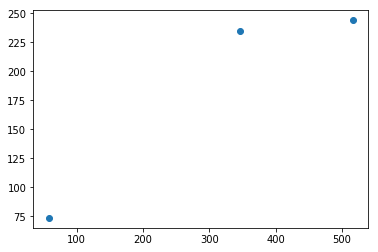

In [23]:
plt.scatter(Y[:,0], Y[:,1])